In [1]:
#Import the Libraries
import os
import cv2
import math
import pickle
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Initialize contants
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

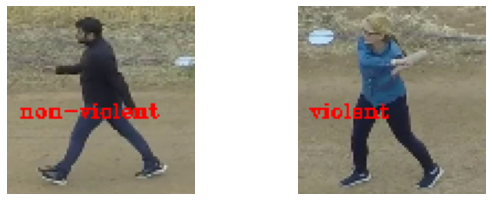

In [5]:
#View Dataset
IMAGE_HEIGHT , IMAGE_WIDTH = 85,85
SEQUENCE_LENGTH = 48

plt.figure(figsize = (20, 20))
data_path = r'.\dataset'
all_classes_names = os.listdir(data_path)

for counter, class_name in enumerate(all_classes_names, 1):
    selected_class_Name = class_name
    video_files_names_list = os.listdir(f'{data_path}/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'{data_path}/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    rgb_frame = cv2.resize(rgb_frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    cv2.putText(rgb_frame, selected_class_Name, (5, 50), cv2.FONT_HERSHEY_TRIPLEX , 0.3, (255, 0, 0), 1)
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

In [6]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

In [7]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(all_classes_names):
        
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(data_path, class_name))
        # print(files_list)

        for file_name in files_list:
            print(files_list.index(file_name),end=" ")
            video_file_path = os.path.join(data_path, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

In [14]:
#Load features & Labels
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: non-violent
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 

In [15]:
#Change Labels to Categorical
labels = to_categorical(labels)

In [18]:
#Split the training & testing features 
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

#Dump to unsplite features to pickle file to load features quickly next time
with open('features.pkl', 'wb') as handle:
    pickle.dump(features, handle)
with open('labels.pkl', 'wb') as handle:
    pickle.dump(labels, handle)

#Clear memory
del features
del labels

In [17]:
#Dump train & test features
with open('features_train.pkl', 'wb') as handle:
    pickle.dump(features_train, handle)
with open('features_test.pkl', 'wb') as handle:
    pickle.dump(features_test, handle)
with open('labels_train.pkl', 'wb') as handle:
    pickle.dump(labels_train, handle)
with open('labels_test.pkl', 'wb') as handle:
    pickle.dump(labels_test, handle)

In [8]:
#Load features from pickle file saved in local storage
with open('.\extracted_features\\features_train.pkl', 'rb') as fp:
    features_train = pickle.load(fp)

with open('.\extracted_features\\labels_train.pkl', 'rb') as file:
    labels_train = pickle.load(file)

print(features_train.shape)

(712, 48, 85, 85, 3)


In [9]:
import tensorflow as tf
IMAGE_HEIGHT , IMAGE_WIDTH = 85,85
SEQUENCE_LENGTH = 48

_Use_Pretrained = False

if(_Use_Pretrained == False):
    model = Sequential()

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Flatten()))
    model.add(GRU(32))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(2, activation = 'sigmoid'))

else:
    pretrained_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0( weights='imagenet', include_top=False, pooling='max')
    video = tf.keras.layers.Input(shape=(16, IMAGE_WIDTH,IMAGE_HEIGHT, 3), name='video_input')
    encoded_frame = pretrained(video)
    encoded_vid = tf.keras.layers.LSTM(units=32,activation='relu')(encoded_frame)
    fc1 = tf.keras.layers.Dense(64, activation='relu')(encoded_vid)
    fc2 = tf.keras.layers.Dense(32, activation='relu')(fc1) 
    outputs = tf.keras.layers.Dense(2, activation='sigmoid')(fc2)
    tf.keras.backend.clear_session()
    model = tf.keras.models.Model(inputs=[video],outputs=outputs)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 48, 85, 85, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 48, 21, 21, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 48, 21, 21, 32)    4640      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 48, 5, 5, 32)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 48, 5, 5, 64)      18496     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 48, 1, 1, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 48, 64)            0

In [10]:
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
# checkpoint = ModelCheckpoint("./model_new",verbose=1, monitor='val_acc',save_best_only=True, mode='max')  
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = ['accuracy'])

model_training_history = model.fit(x=features_train, y = labels_train, epochs = 10, batch_size = 4, shuffle = True,validation_split = 0.2)

Epoch 1/10
143/143 [==============================] - 120s 656ms/step - loss: 0.6886 - accuracy: 0.5448 - val_loss: 0.6854 - val_accuracy: 0.5385
Epoch 2/10
143/143 [==============================] - 46s 323ms/step - loss: 0.6810 - accuracy: 0.5554 - val_loss: 0.6751 - val_accuracy: 0.5385
Epoch 3/10
143/143 [==============================] - 45s 316ms/step - loss: 0.6332 - accuracy: 0.6573 - val_loss: 0.5080 - val_accuracy: 0.7972
Epoch 4/10
143/143 [==============================] - 44s 311ms/step - loss: 0.5202 - accuracy: 0.7557 - val_loss: 0.4416 - val_accuracy: 0.8322
Epoch 5/10
143/143 [==============================] - 47s 326ms/step - loss: 0.4629 - accuracy: 0.7909 - val_loss: 0.6152 - val_accuracy: 0.7273
Epoch 6/10
143/143 [==============================] - 57s 401ms/step - loss: 0.2384 - accuracy: 0.9192 - val_loss: 0.4912 - val_accuracy: 0.8042
Epoch 7/10
143/143 [==============================] - 47s 327ms/step - loss: 0.1761 - accuracy: 0.9490 - val_loss: 0.1646 - val_a

In [17]:
# Clear memory
del features_train
del labels_train

#Load test features
with open('.//extracted_features//features_test.pkl', 'rb') as file:
    features_test = pickle.load(file)

with open('.//extracted_features//labels_test.pkl', 'rb') as file:
    labels_test = pickle.load(file)


In [18]:
model_evaluation_history = model.evaluate(features_test, labels_test)

6/6 [==============================] - 4s 632ms/step - loss: 0.1069 - accuracy: 0.9609


In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print("[INFO] evaluating network...")

predictions = model.predict(x=features_test.astype("float32"))
print(classification_report(labels_test.argmax(axis=1),predictions.argmax(axis=1), target_names=all_classes_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

 non-violent       0.93      1.00      0.96        88
     violent       1.00      0.92      0.96        91

    accuracy                           0.96       179
   macro avg       0.96      0.96      0.96       179
weighted avg       0.96      0.96      0.96       179



In [20]:
print(confusion_matrix(labels_test.argmax(axis=1),predictions.argmax(axis=1)))

[[88  0]
 [ 7 84]]


In [11]:
#save model
# model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_file_name = f'gru__sigmoid_model___Date_Time_{current_date_time_string}___Loss_{model_training_history.history["val_loss"][9]}___Accuracy_{model_training_history.history["val_accuracy"][9]}.h5'
model.save(model_file_name)

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

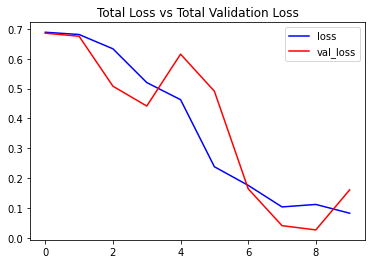

In [22]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

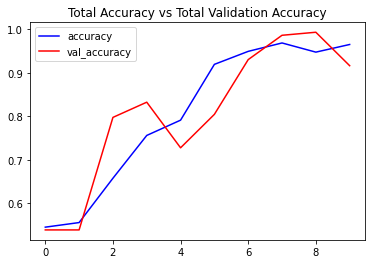

In [23]:
plot_metric(model_training_history, "accuracy" , 'val_accuracy' , 'Total Accuracy vs Total Validation Accuracy')